In [1]:
#importing Libraries
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from sklearn.linear_model import LogisticRegression
from joblib import dump
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

In [2]:
# Reading the training data from 'multimodal_train.tsv' using tab as the separator
df = pd.read_csv('multimodal_train.tsv', sep='\t')

# Selecting only the columns '2_way_label' and 'title' from the training DataFrame
df = df[["2_way_label", "title"]]

# Renaming the '2_way_label' column to 'label' for better representation
df = df.rename(columns={'2_way_label': 'label'})

# Reading the test data from 'multimodal_test_public.tsv' using tab as the separator
df_test = pd.read_csv('multimodal_test_public.tsv', sep='\t')

# Selecting only the columns '2_way_label' and 'title' from the test DataFrame
df_test = df_test[["2_way_label", "title"]]

# Renaming the '2_way_label' column to 'label' in the test DataFrame for consistency
df_test = df_test.rename(columns={'2_way_label': 'label'})


Text(0.5, 1.0, 'Distribution of Fake/Real News')

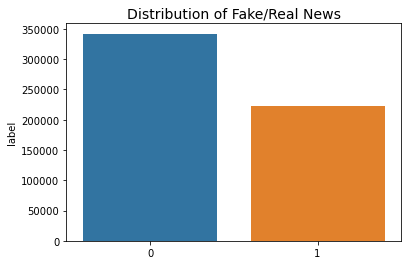

In [3]:
# Extracting the labels from the training DataFrame
y = df.label

# Displaying the normalized value counts of labels in the training data
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

# Extracting the labels from the test DataFrame
y_testing = df_test.label

# Displaying the normalized value counts of labels in the test data
y_testing.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

# Defining class names for better interpretation
class_names = ['fake', 'real']

# Counting the occurrences of each label in the training data
label_count = df.label.value_counts()

# Creating a bar plot to visualize the distribution of fake and real news
sns.barplot(x=label_count.index, y=label_count)

# Setting the title for the plot
plt.title('Distribution of Fake/Real News', fontsize=14)


In [4]:
# Dropping rows with null values in the training DataFrame
df = df.dropna()

# Dropping rows with null values in the test DataFrame
df_test = df_test.dropna()


In [5]:
# Extracting the 'title' column as the feature for training data
X_train = df['title']

# Extracting the 'title' column as the feature for test data
X_test = df_test['title']

# Extracting the 'label' column as the target for training data
y_train = df['label']

# Extracting the 'label' column as the target for test data
y_test = df_test['label']


In [6]:
# Define a custom tokenizer function that extracts lowercase words from the text
def custom_tokenizer(text):
    tokens = re.findall(r'\b\w+\b', text)
    tokens = [token.lower() for token in tokens]  
    return tokens

# Create a CountVectorizer with the custom tokenizer, using n-grams of size 1 to 3 and excluding English stop words
count_vectorizer = CountVectorizer(tokenizer=custom_tokenizer, ngram_range=(1, 3), stop_words='english')

# Fit and transform the training data using the CountVectorizer
count_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted CountVectorizer
count_test = count_vectorizer.transform(X_test)


In [7]:
# Define a function to plot a graph with training and test scores
def plot_graph(x, train_score, test_score, x_label, title):
    plt.plot(x, train_score, color='green', label='Train')
    plt.plot(x, test_score, color='red', label='Test')
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9


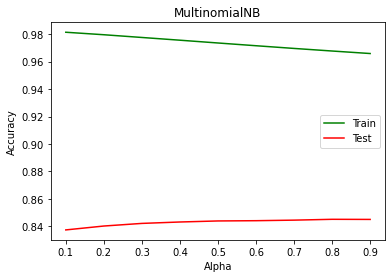

In [8]:
# Initialize empty lists to store training and test scores
train_score = []
test_score = []

# Define a range of alpha values
alpha = np.arange(0.1, 1, 0.1)

# Loop through each alpha value and train a Multinomial Naive Bayes model
for index in alpha:
    # Create a Multinomial Naive Bayes model with the specified alpha
    model = MultinomialNB(alpha=index)
    
    # Fit the model using the training data
    model.fit(count_train, y_train)
    
    # Predict labels for the training data
    y_hat_train = model.predict(count_train)
    
    # Calculate the confusion matrix for the training data
    cm_train = metrics.confusion_matrix(y_train, y_hat_train)
    
    # Calculate and append the training accuracy to the list
    train_score.append(cm_train.diagonal().sum() / cm_train.sum())
    
    # Predict labels for the test data
    y_hat_test = model.predict(count_test)
    
    # Calculate the confusion matrix for the test data
    cm_test = metrics.confusion_matrix(y_test, y_hat_test)
    
    # Calculate and append the test accuracy to the list
    test_score.append(cm_test.diagonal().sum() / cm_test.sum())

# Plot the graph with the obtained training and test scores
plot_graph(alpha, train_score, test_score, "Alpha", "MultinomialNB")


In [ ]:
# Initialize empty lists to store training and test scores
train_score = []
test_score = []

# Define a range of max_depth values
max_depth = np.arange(2, 30)

# Loop through each max_depth value and train a Decision Tree model
for index in max_depth:
    # Create a Decision Tree model with the specified max_depth and criterion='entropy'
    model = DecisionTreeClassifier(criterion='entropy', max_depth=index)
    
    # Fit the model using the training data
    model.fit(count_train, y_train)
    
    # Predict labels for the training data
    y_hat_train = model.predict(count_train)
    
    # Calculate the confusion matrix for the training data
    cm_train = metrics.confusion_matrix(y_train, y_hat_train)
    
    # Calculate and append the training accuracy to the list
    accuracy_train = cm_train.diagonal().sum() / cm_train.sum()
    train_score.append(accuracy_train)
    
    # Predict labels for the test data
    y_hat_test = model.predict(count_test)
    
    # Calculate the confusion matrix for the test data
    cm_test = metrics.confusion_matrix(y_test, y_hat_test)
    
    # Calculate and append the test accuracy to the list
    accuracy_test = cm_test.diagonal().sum() / cm_test.sum()
    test_score.append(accuracy_test)

# Plot the graph with the obtained training and test scores
plot_graph(max_depth, train_score, test_score, 'Max Depth', 'Decision Tree')


In [ ]:
# Initialize empty lists to store training and test scores
train_score = []
test_score = []

# Create an XGBoost Classifier with a specified learning rate
model = xgb.XGBClassifier(learning_rate=0.1)

# Fit the model using the training data
model.fit(count_train, y_train)

# Predict labels for the training data
y_hat_train = model.predict(count_train)

# Calculate the confusion matrix for the training data
cm_train = confusion_matrix(y_train, y_hat_train)

# Calculate and append the training accuracy to the list
train_score.append(cm_train.diagonal().sum() / cm_train.sum())

# Predict labels for the test data
y_hat_test = model.predict(count_test)

# Calculate the confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_hat_test)

# Calculate and append the test accuracy to the list
test_score.append(cm_test.diagonal().sum() / cm_test.sum())


In [ ]:
model = xgb.XGBClassifier(learning_rate=0.2)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.3)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.4)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.5)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.6)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.7)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.8)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())

In [ ]:
model = xgb.XGBClassifier(learning_rate=0.9)  # Corrected learning_rate parameter
model.fit(count_train, y_train)
y_hat_train = model.predict(count_train)
cm_train = confusion_matrix(y_train, y_hat_train)
train_score.append(cm_train.diagonal().sum() / cm_train.sum())
y_hat_test = model.predict(count_test)
cm_test = confusion_matrix(y_test, y_hat_test)
test_score.append(cm_test.diagonal().sum() / cm_test.sum())
plot_graph(np.arange(0.1,1,0.1),train_score,test_score,"alpha","XGBClassifier")

In [ ]:
# Initialize empty lists to store training and test scores
train_score = []
test_score = []

# Define a range of C values
C_values = np.arange(0.1, 1, 0.1)

# Loop through each C value and train a Logistic Regression model
for C_val in C_values:
    # Create a Logistic Regression model with the specified C value and maximum iterations
    model = LogisticRegression(C=C_val, max_iter=500)
    
    # Fit the model using the training data
    model.fit(count_train, y_train)
    
    # Predict labels for the training data
    y_hat_train = model.predict(count_train)
    
    # Calculate the confusion matrix for the training data
    cm_train = confusion_matrix(y_train, y_hat_train)
    
    # Calculate and append the training accuracy to the list
    train_score.append(cm_train.diagonal().sum() / cm_train.sum())
    
    # Predict labels for the test data
    y_hat_test = model.predict(count_test)
    
    # Calculate the confusion matrix for the test data
    cm_test = confusion_matrix(y_test, y_hat_test)
    
    # Calculate and append the test accuracy to the list
    test_score.append(cm_test.diagonal().sum() / cm_test.sum())

# Plot the graph with the obtained training and test scores
plot_graph(C_values, train_score, test_score, "C", "LogisticRegression")


In [17]:
# Create a Logistic Regression model with regularization parameter C=0.9 and maximum iterations set to 500
model = LogisticRegression(C=0.9, max_iter=500)

# Fit the model using the training data and its corresponding labels
model.fit(count_train, y_train)

# Predict labels for the training data
y_hat_train = model.predict(count_train)

# Calculate the confusion matrix for the training data
cm_train = confusion_matrix(y_train, y_hat_train)

# Calculate the training accuracy
train_score = (cm_train.diagonal().sum() / cm_train.sum())

# Predict labels for the test data
y_hat_test = model.predict(count_test)

# Calculate the confusion matrix for the test data
cm_test = confusion_matrix(y_test, y_hat_test)

# Calculate the test accuracy
test_score = (cm_test.diagonal().sum() / cm_test.sum())


0.977354609929078
0.8690133009659637


In [15]:
# Save the trained Logistic Regression model to a file using joblib
dump(model, 'Classifier.joblib')

# Save the fitted CountVectorizer to a file using joblib
dump(count_vectorizer, 'Count_Vectorizer.joblib')


['Count_Vectorizer.joblib']